In [68]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/brasilian-houses-to-rent/houses_to_rent.csv
/kaggle/input/brasilian-houses-to-rent/houses_to_rent_v2.csv


In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import catboost
from catboost import Pool
import xgboost
import optuna
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

In [70]:
df = pd.read_csv('/kaggle/input/brasilian-houses-to-rent/houses_to_rent_v2.csv')

In [71]:
df.head()

,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$),total (R$)
0,São Paulo,70,2,1,1,7,acept,furnished,2065,3300,211,42,5618
1,São Paulo,320,4,4,0,20,acept,not furnished,1200,4960,1750,63,7973
2,Porto Alegre,80,1,1,1,6,acept,not furnished,1000,2800,0,41,3841
3,Porto Alegre,51,2,1,0,2,acept,not furnished,270,1112,22,17,1421
4,São Paulo,25,1,1,0,1,not acept,not furnished,0,800,25,11,836


In [72]:
df.columns

Index(['city', 'area', 'rooms', 'bathroom', 'parking spaces', 'floor',
       'animal', 'furniture', 'hoa (R$)', 'rent amount (R$)',
       'property tax (R$)', 'fire insurance (R$)', 'total (R$)'],
      dtype='object')

In [73]:
#df.columns = ['city', 'area', 'rooms', 'bathroom', 'parking spaces', 'floor',
#       'animal', 'furniture', 'hoa', 'rent amount',
#       'property tax', 'fire insurance', 'total']

In [74]:
def categorise(data,cols):
    object_cols = []
    num_cols = []
    for i in cols:
        if data[i].dtype == 'object':
            object_cols.append(i)
        else:
            num_cols.append(i)
    return object_cols, num_cols

In [75]:
object_cols, num_cols = categorise(df,df.columns)
object_cols, num_cols

(['city', 'floor', 'animal', 'furniture'],
 ['area',
  'rooms',
  'bathroom',
  'parking spaces',
  'hoa (R$)',
  'rent amount (R$)',
  'property tax (R$)',
  'fire insurance (R$)',
  'total (R$)'])

So, four columns i.e. 'city', 'floor', 'animal', 'furniture' have values other than a numerical one. Now, let's first check if the data contains any NaN values.

In [76]:
df.isnull().sum()

city                   0
area                   0
rooms                  0
bathroom               0
parking spaces         0
floor                  0
animal                 0
furniture              0
hoa (R$)               0
rent amount (R$)       0
property tax (R$)      0
fire insurance (R$)    0
total (R$)             0
dtype: int64

Clearly, data not contains any NaN values. Let's check what all different values the object_cols has.

In [77]:
df['city'].unique()

array(['São Paulo', 'Porto Alegre', 'Rio de Janeiro', 'Campinas',
       'Belo Horizonte'], dtype=object)

Since, 'city' column contains 5 different values, so we'll use one_hot_encorder.

In [78]:
df['floor'].unique()

array(['7', '20', '6', '2', '1', '-', '4', '3', '10', '11', '24', '9',
       '8', '17', '18', '5', '13', '15', '16', '14', '26', '12', '21',
       '19', '22', '27', '23', '35', '25', '46', '28', '29', '301', '51',
       '32'], dtype=object)

'floor' contains '-', it has to be removed. 

In [79]:
df.loc[df['floor'] == '-', 'floor'] = 0
df['floor'] = df['floor'].astype('int64')

In [80]:
df['animal'].unique()

array(['acept', 'not acept'], dtype=object)

In [81]:
df['furniture'].unique()

array(['furnished', 'not furnished'], dtype=object)

# Checking for outliers

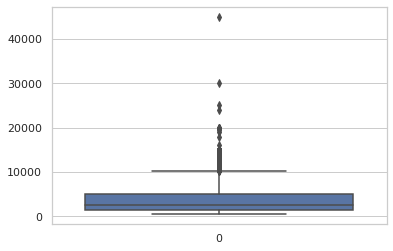

In [82]:
sns.boxplot(data=df['rent amount (R$)'])

**We can see that there are some outliers, so we have to remove them**

# Removing outliers

In [83]:
df1 = df.copy()

In [84]:
df1.head()

,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$),total (R$)
0,São Paulo,70,2,1,1,7,acept,furnished,2065,3300,211,42,5618
1,São Paulo,320,4,4,0,20,acept,not furnished,1200,4960,1750,63,7973
2,Porto Alegre,80,1,1,1,6,acept,not furnished,1000,2800,0,41,3841
3,Porto Alegre,51,2,1,0,2,acept,not furnished,270,1112,22,17,1421
4,São Paulo,25,1,1,0,1,not acept,not furnished,0,800,25,11,836


In [85]:
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

In [86]:
df2 = remove_outlier(df1, 'rent amount (R$)')

In [87]:
df2.shape

(9977, 13)

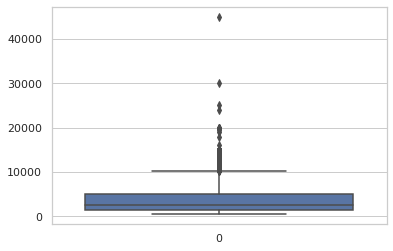

In [88]:
sns.boxplot(data=df['rent amount (R$)'])

Text(0.5, 1.0, 'After Removing Outliers')

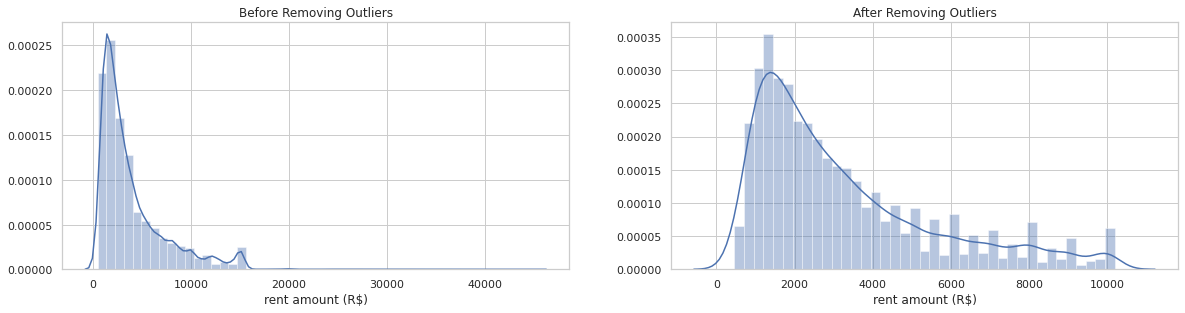

In [89]:
# Lets take a look on how our data was distributed before and after treat outliers

plt.figure(1, figsize=(20, 10))
plt.subplot(2, 2, 1)
sns.distplot(df['rent amount (R$)'])
plt.title('Before Removing Outliers')
plt.subplot(2, 2, 2)
sns.distplot(df2['rent amount (R$)'])
plt.title('After Removing Outliers')

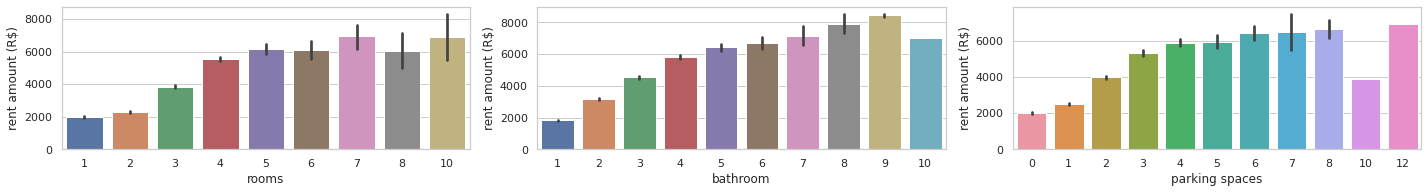

In [90]:
num_cols1 = ['rooms', 'bathroom', 'parking spaces']
plt.figure(figsize=(20, 5))
sns.set(style = 'whitegrid')
i = 1
for feature in num_cols1:
    plt.subplot(2, 3, i)
    sns.barplot(x = feature, y= 'rent amount (R$)', data=df2)
    i+=1
plt.tight_layout()

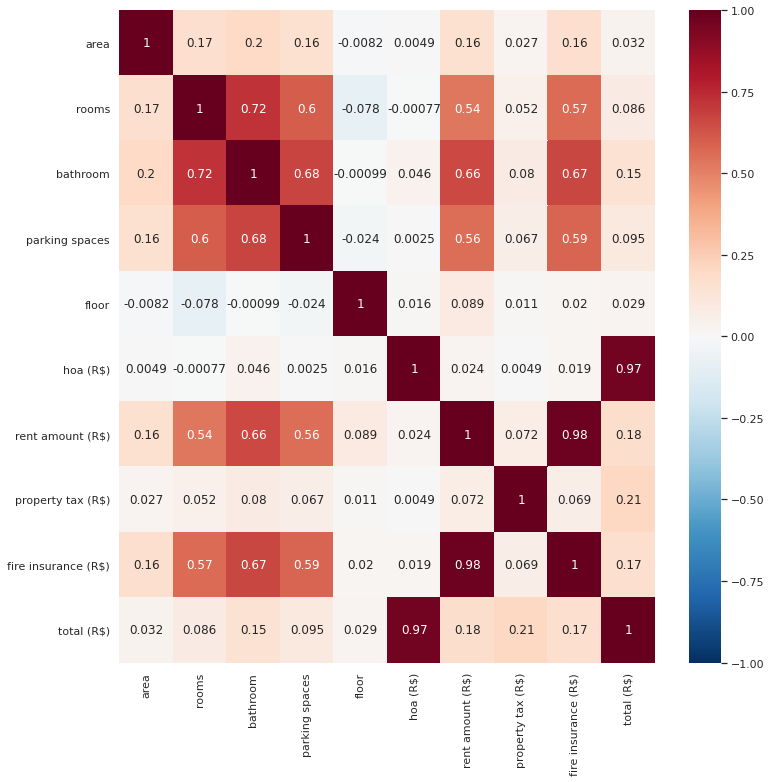

In [29]:
# now let's see the correlation between features
plt.figure(figsize=(12,12))
sns.heatmap(df2.corr(), annot=True, cmap='RdBu_r', linecolor='black',vmin=-1, vmax=1)

In [91]:
lev_enc = LabelEncoder()
df2['animal']=lev_enc.fit_transform(df2['animal'])
df2['furniture']=lev_enc.fit_transform(df2['furniture'])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [92]:
df2.head()

,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$),total (R$)
0,São Paulo,70,2,1,1,7,0,0,2065,3300,211,42,5618
1,São Paulo,320,4,4,0,20,0,1,1200,4960,1750,63,7973
2,Porto Alegre,80,1,1,1,6,0,1,1000,2800,0,41,3841
3,Porto Alegre,51,2,1,0,2,0,1,270,1112,22,17,1421
4,São Paulo,25,1,1,0,1,1,1,0,800,25,11,836


In [93]:
hot_enc = pd.get_dummies(df2['city'])

In [94]:
df_final = pd.concat([df2, hot_enc], axis=1)

In [95]:
df_final.drop(['city'], axis=1, inplace=True)

In [97]:
df_final.head(10)

,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$),total (R$),Belo Horizonte,Campinas,Porto Alegre,Rio de Janeiro,São Paulo
0,70,2,1,1,7,0,0,2065,3300,211,42,5618,0,0,0,0,1
1,320,4,4,0,20,0,1,1200,4960,1750,63,7973,0,0,0,0,1
2,80,1,1,1,6,0,1,1000,2800,0,41,3841,0,0,1,0,0
3,51,2,1,0,2,0,1,270,1112,22,17,1421,0,0,1,0,0
4,25,1,1,0,1,1,1,0,800,25,11,836,0,0,0,0,1
5,376,3,3,7,0,0,1,0,8000,834,121,8955,0,0,0,0,1
6,72,2,1,0,7,0,1,740,1900,85,25,2750,0,0,0,1,0
7,213,4,4,4,4,0,1,2254,3223,1735,41,7253,0,0,0,0,1
9,35,1,1,0,2,0,0,590,2300,35,30,2955,0,0,0,1,0
10,26,1,1,0,2,0,0,470,2100,150,27,2747,0,0,0,0,1


In [98]:
columns = ['Belo Horizonte','Campinas', 'Porto Alegre', 'Rio de Janeiro', 'São Paulo', 'rooms', 'bathroom', 'parking spaces', 'fire insurance (R$)',
        'furniture']
X = df_final[columns]
y = df_final['rent amount (R$)']

In [99]:
X_train, X_valid, y_train, y_valid = train_test_split(X,y, test_size=0.2, random_state=0)

In [100]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9977 entries, 0 to 10691
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Belo Horizonte       9977 non-null   uint8
 1   Campinas             9977 non-null   uint8
 2   Porto Alegre         9977 non-null   uint8
 3   Rio de Janeiro       9977 non-null   uint8
 4   São Paulo            9977 non-null   uint8
 5   rooms                9977 non-null   int64
 6   bathroom             9977 non-null   int64
 7   parking spaces       9977 non-null   int64
 8   fire insurance (R$)  9977 non-null   int64
 9   furniture            9977 non-null   int64
dtypes: int64(5), uint8(5)
memory usage: 836.4 KB


In [101]:
train_pool = Pool(
                data = X_train,
                label = y_train,
)
valid_pool = Pool(
                data = X_valid,
                label = y_valid,
)

In [103]:
model = catboost.CatBoostRegressor(custom_metric= ['R2', 'RMSE'], learning_rate=0.1, n_estimators=264)
model.fit(train_pool, eval_set=valid_pool, verbose=50, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 2083.5212712	test: 2097.8926559	best: 2097.8926559 (0)	total: 26.8ms	remaining: 7.05s
50:	learn: 318.3449678	test: 312.1900281	best: 312.1900281 (50)	total: 189ms	remaining: 791ms
100:	learn: 293.3709079	test: 295.1893895	best: 295.1893895 (100)	total: 347ms	remaining: 560ms
150:	learn: 279.9967645	test: 287.7223531	best: 287.7223531 (150)	total: 502ms	remaining: 376ms
200:	learn: 269.7647863	test: 285.1388939	best: 285.1388939 (200)	total: 672ms	remaining: 211ms
250:	learn: 261.8529611	test: 283.2602432	best: 283.2324084 (249)	total: 829ms	remaining: 42.9ms
263:	learn: 259.7589348	test: 283.0593342	best: 283.0593342 (263)	total: 873ms	remaining: 0us

bestTest = 283.0593342
bestIteration = 263



In [104]:
# we create a list to storage all the results for later visualization
acc = []
# parameters are the alpha's that we will use to perform the GridSearch
parameters1= [{'alpha': [0.0001, 0.001, 0.1, 1, 10, 100, 1000, 10000, 100000, 100000]}]
# on the regressors we define the models that we want use
regressors = {'Linear Regression': LinearRegression(),
              'Ridge Model': Ridge(alpha=0.1),
              'Decision Tree': DecisionTreeRegressor(),
              'Random Forest': RandomForestRegressor(random_state=1),
              'SVR': SVR(),
              'KNN': KNeighborsRegressor(),
              'Lasso': Lasso(),
              'GridSearchRidge': GridSearchCV(Ridge(), parameters1, cv=4),
              'GridSearchLasso': GridSearchCV(Lasso(), parameters1, cv=4)
             }

In [105]:
# now we perform a loop with each regressor to perform the model, predict the rent 
# and extract the metrics
for i in regressors:
    model = regressors.get(i)
    # here we create a condition because for grid we want to perform the model with the best estimator
    if i == 'GridSearchRidge' or i == 'GridSearchLasso':
        model.fit(X_train, y_train).best_estimator_ 
    model.fit(X_train, y_train)
    prediction = model.predict(X_valid)
    print(i)
    print('MAE:', mean_absolute_error(y_valid, prediction))
    print('RMSE:', np.sqrt(mean_squared_error(y_valid, prediction)))
    print('R2:', r2_score(y_valid, prediction))
    print('*' * 40)
    acc.append([i, mean_absolute_error(y_valid, prediction), np.sqrt(mean_squared_error(y_valid, prediction)), r2_score(y_valid, prediction)])


Linear Regression
MAE: 254.68092609170725
RMSE: 380.28249683094924
R2: 0.9728310263274295
****************************************
Ridge Model
MAE: 254.6782640533529
RMSE: 380.28278239466925
R2: 0.9728309855236787
****************************************
Decision Tree
MAE: 145.7152239914486
RMSE: 361.7913374019405
R2: 0.9754089604858316
****************************************
Random Forest
MAE: 139.3669633465181
RMSE: 295.7515370522144
R2: 0.9835670860805055
****************************************
SVR
MAE: 791.5906866662164
RMSE: 1431.187143560729
R2: 0.6151837420424755
****************************************
KNN
MAE: 159.48226452905814
RMSE: 324.24434856316356
R2: 0.9802482586410964
****************************************
Lasso
MAE: 253.47576266176034
RMSE: 380.5180724542027
R2: 0.9727973548837621
****************************************
GridSearchRidge
MAE: 254.41867390806738
RMSE: 380.31282260073
R2: 0.9728266929547418
****************************************


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15133034.142350674, tolerance: 3147495.995213968
  positive)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15009026.560471892, tolerance: 3150825.7857793686
  positive)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15865261.818148136, tolerance: 3126307.2603377383
  positive)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1578530

GridSearchLasso
MAE: 254.6808142441016
RMSE: 380.2825186650068
R2: 0.9728310232075964
****************************************


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20610606.057421803, tolerance: 4196538.02025859
  positive)


In [ ]:
# now let's follow the same loop and visualize the plot's for each regressor
j = 1
plt.figure(figsize=(20,10))
for i in regressors:
    model = regressors.get(i)
    model.fit(X_train, y_train)
    prediction = model.predict(X_valid)
    plt.subplot(3, 3, j)
    plt.title(i)
    ax1 = sns.distplot(y_valid,hist=False,kde =True,color ="r",label ="Actual Value")
    sns.distplot(prediction ,color ="b",hist = False,kde =True, label = "Predicted Value",ax =ax1).set_title(i)
    j+=1
plt.tight_layout(pad = 0.5)